In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
from scipy.special import erf,erfinv,gammaincinv,gamma
import json
import h5py
mpl.style.use('./../figures/plotting.mplstyle')
import sys
sys.path.append('./../figures/')
from makeCorner import *

## Case 1: Gaussian

---
Load the sumary file containing output of our autoregressive inference over our mock posteriors, assuming a Gaussian population:

In [2]:
hdata = h5py.File("./ar_gaussian_varyingUncertainty_069_summary.hdf","r")

# List attributes
for key in hdata.attrs.keys():
    print("{0}: {1}".format(key,hdata.attrs[key]))
    
# List groups and datasetes
print("\nGroups:")
print(hdata.keys())

print("\nData sets inside ['posterior']:")
print(hdata['posterior'].keys())

Created_by: process_mock_populations.py
Downloadable_from: 10.5281/zenodo.7600141
Source_code: https://github.com/tcallister/autoregressive-bbh-inference

Groups:
<KeysViewHDF5 ['posterior']>

Data sets inside ['posterior']:
<KeysViewHDF5 ['R_ref', 'ar_std', 'ar_tau', 'chis', 'dR_dchis', 'fs', 'min_log_neff', 'nEff_inj_per_event']>


---
The different `hdata['posterior/']` datasets correspond to the following:

| Name      | Description |
| :---------- | :---------- |
| `R_ref`     | The mean on our AR1 process  |
| `ar_std` | The square of this is the prior variance of our AR process |
| `ar_tau` | The autocorrelation length of our AR process |
| `chis` | The set of mock samples over which `dR_dchis` and `fs` are defined |
| `dR_dchis` | The source-frame volumetric merger $\frac{d\mathcal{R}}{d\chi}$ with units $\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}$ |
| `fs` | The logarithm of this quantity is our AR1 process over $\chi$; this quantity is proportional to `dR_dchis` |
| `nEff_inj_per_event` | Number of effective injections per event informing our Monte Carlo estimate of detection efficiency |
| `min_log_neff` | For each posterior sample, minimum (log10) number of effective posterior samples informing our Monte Carlo estimates of each event's likelihood, taken over all events |

Make a big corner plot of all these quantities:

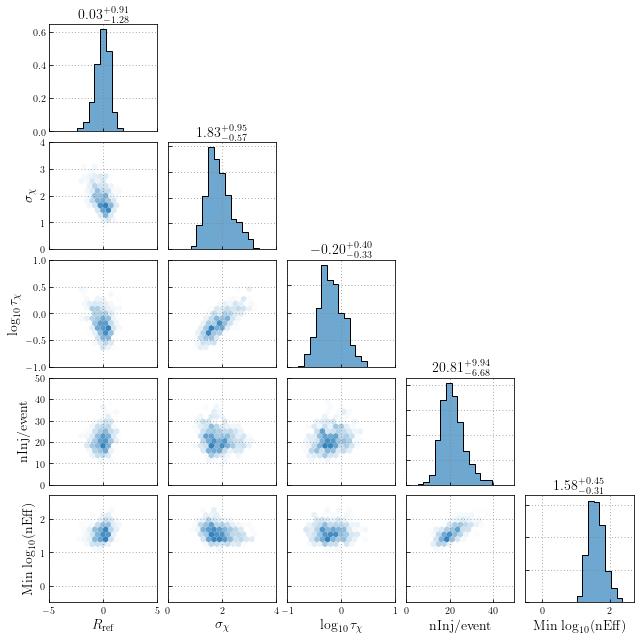

In [3]:
plot_data = {
    'R_ref':{'data':np.log10(hdata['posterior/R_ref'][()]),'plot_bounds':(-5,5),'label':r'$R_\mathrm{ref}$'},
    'ar_std':{'data':hdata['posterior/ar_std'][()],'plot_bounds':(0,4),'label':r'$\sigma_{\chi}$'},
    'ar_tau':{'data':np.log10(hdata['posterior/ar_tau'][()]),'plot_bounds':(-1,1),'label':r'$\log_{10}\tau_{\chi}$'},
    'neff':{'data':hdata['posterior/nEff_inj_per_event'][()],'plot_bounds':(0,50),'label':r'nInj/event'},
    'min_neff':{'data':hdata['posterior/min_log_neff'][()],'plot_bounds':(-0.5,2.7),'label':r'Min $\log_{10}$(nEff)'},
}

fig = plt.figure(figsize=(9,9))
plot_corner(fig,plot_data,'#3182bd')
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()

---
Now let's plot the inferred distribution over $\chi$. We can do this two ways:
* The inferred probability distribution $p(\chi)$, or
* The inferred rate density $d\mathcal{R}/d\chi$

Start with a probability density:

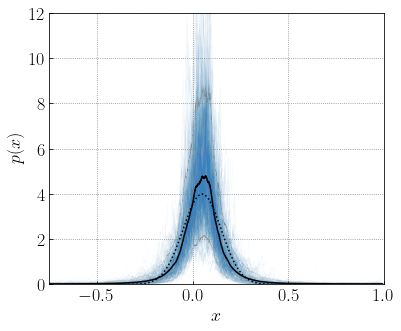

In [4]:
# Read out chi samples and the AR(1) process posteriors
sample_values = np.array(hdata['posterior/chis'])
fs = np.array(hdata['posterior/fs'])

# Loop across samples and normalize to construct a probability density
ps = np.zeros((sample_values.size,fs.shape[1]))
for i in range(fs.shape[1]):
    ps[:,i] = fs[:,i]/np.trapz(fs[:,i],sample_values)

# Plot a random subset of probability distribution posteriors
fig,ax = plt.subplots(figsize=(6,5))
for i in np.random.choice(range(fs.shape[1]),300):
    ax.plot(sample_values,ps[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

# Highlight the mean and a central 90% credible interval
ax.plot(sample_values,np.mean(ps,axis=1),color='black')
ax.plot(sample_values,np.quantile(ps,0.05,axis=1),color='grey',lw=0.15)
ax.plot(sample_values,np.quantile(ps,0.95,axis=1),color='grey',lw=0.15)

# Overplot with the *true* injected probability distribution
xs = np.linspace(-1,1,300)
true_mu = 0.05
true_sig = 0.1
ys = np.exp(-(xs-true_mu)**2/(2.*true_sig**2))/np.sqrt(2.*np.pi*true_sig**2)
ax.plot(xs,ys,color='black',ls=':')

# Misc formatting
ax.set_xlim(-0.75,1)
ax.set_ylim(0,12)
ax.tick_params(labelsize=18)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$p(x)$',fontsize=18)

plt.show()

---
Next plot our recovery of the actual rate density:

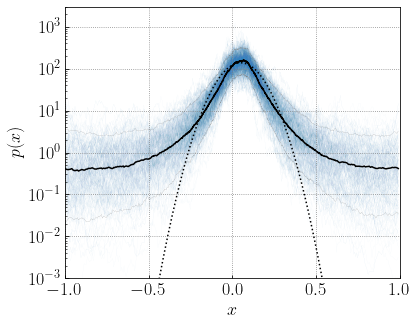

In [5]:
# Read out rates (note that `dR_dchis = R_ref*fs`)
dR_dchis = np.array(hdata['posterior/dR_dchis'])

# Plot a random subset of traces
fig,ax = plt.subplots(figsize=(6,5))
for i in np.random.choice(range(dR_dchis.shape[1]),300):
    ax.plot(sample_values,dR_dchis[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

# Highlight median and 90% credible bounds
ax.plot(sample_values,np.median(dR_dchis,axis=1),color='black')
ax.plot(sample_values,np.quantile(dR_dchis,0.05,axis=1),color='grey',lw=0.15)
ax.plot(sample_values,np.quantile(dR_dchis,0.95,axis=1),color='grey',lw=0.15)

# Show *true* rate density
# Note that we are assuming we have observed Nobs = 69 events spread over T=2 years
xs = np.linspace(-1,1,300)
true_mu = 0.05
true_sig = 0.1
ys = (69./2)*np.exp(-(xs-true_mu)**2/(2.*true_sig**2))/np.sqrt(2.*np.pi*true_sig**2)
ax.plot(xs,ys,color='black',ls=':')

# Misc formatting
ax.set_xlim(-1,1)
ax.set_ylim(1e-3,3e3)
ax.tick_params(labelsize=18)
ax.set_yscale('log')
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$p(x)$',fontsize=18)

plt.show()

## Case 2: Spike

---
Load the sumary file containing output of our autoregressive inference over mock posteriors, assuming a delta-function population

In [6]:
hdata = h5py.File("./ar_spike_varyingUncertainty_069_summary.hdf","r")

# List attributes
for key in hdata.attrs.keys():
    print("{0}: {1}".format(key,hdata.attrs[key]))
    
# List groups and datasetes
print("\nGroups:")
print(hdata.keys())

print("\nData sets inside ['posterior']:")
print(hdata['posterior'].keys())

Created_by: process_mock_populations.py
Downloadable_from: 10.5281/zenodo.7600141
Source_code: https://github.com/tcallister/autoregressive-bbh-inference

Groups:
<KeysViewHDF5 ['posterior']>

Data sets inside ['posterior']:
<KeysViewHDF5 ['R_ref', 'ar_std', 'ar_tau', 'chis', 'dR_dchis', 'fs', 'min_log_neff', 'nEff_inj_per_event']>


---
The different `hdata['posterior/']` datasets correspond to the following:

| Name      | Description |
| :---------- | :---------- |
| `R_ref`     | The mean on our AR1 process  |
| `ar_std` | The square of this is the prior variance of our AR process |
| `ar_tau` | The autocorrelation length of our AR process |
| `chis` | The set of mock samples over which `dR_dchis` and `fs` are defined |
| `dR_dchis` | The source-frame volumetric merger $\frac{d\mathcal{R}}{d\chi}$ with units $\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}$ |
| `fs` | The logarithm of this quantity is our AR1 process over $\chi$; this quantity is proportional to `dR_dchis` |
| `nEff_inj_per_event` | Number of effective injections per event informing our Monte Carlo estimate of detection efficiency |
| `min_log_neff` | For each posterior sample, minimum (log10) number of effective posterior samples informing our Monte Carlo estimates of each event's likelihood, taken over all events |

Make a big corner plot of all these quantities:

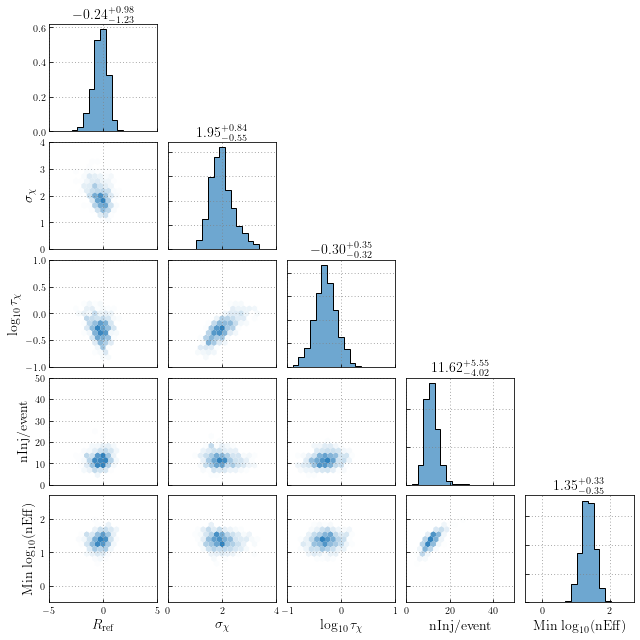

In [7]:
plot_data = {
    'R_ref':{'data':np.log10(hdata['posterior/R_ref'][()]),'plot_bounds':(-5,5),'label':r'$R_\mathrm{ref}$'},
    'ar_std':{'data':hdata['posterior/ar_std'][()],'plot_bounds':(0,4),'label':r'$\sigma_{\chi}$'},
    'ar_tau':{'data':np.log10(hdata['posterior/ar_tau'][()]),'plot_bounds':(-1,1),'label':r'$\log_{10}\tau_{\chi}$'},
    'neff':{'data':hdata['posterior/nEff_inj_per_event'][()],'plot_bounds':(0,50),'label':r'nInj/event'},
    'min_neff':{'data':hdata['posterior/min_log_neff'][()],'plot_bounds':(-0.5,2.7),'label':r'Min $\log_{10}$(nEff)'},
}

fig = plt.figure(figsize=(9,9))
plot_corner(fig,plot_data,'#3182bd')
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()

---
Now let's plot the inferred distribution over $\chi$. We can do this two ways:
* The inferred probability distribution $p(\chi)$, or
* The inferred rate density $d\mathcal{R}/d\chi$

Start with a probability density:

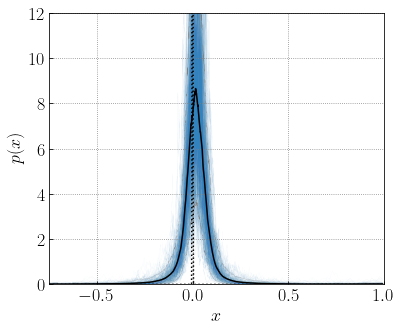

In [8]:
# Read out chi samples and the AR(1) process posteriors
sample_values = np.array(hdata['posterior/chis'])
fs = np.array(hdata['posterior/fs'])

# Loop across samples and normalize to construct a probability density
ps = np.zeros((sample_values.size,fs.shape[1]))
for i in range(fs.shape[1]):
    ps[:,i] = fs[:,i]/np.trapz(fs[:,i],sample_values)

# Plot a random subset of probability distribution posteriors
fig,ax = plt.subplots(figsize=(6,5))
for i in np.random.choice(range(fs.shape[1]),300):
    ax.plot(sample_values,ps[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

# Highlight the mean and a central 90% credible interval
ax.plot(sample_values,np.mean(ps,axis=1),color='black')
ax.plot(sample_values,np.quantile(ps,0.05,axis=1),color='grey',lw=0.15)
ax.plot(sample_values,np.quantile(ps,0.95,axis=1),color='grey',lw=0.15)

# Overplot with the *true* injected probability distribution
# Give the delta function a tiny width to help with visibility
xs = np.linspace(-1,1,1000)
ys = np.exp(-xs**2/(2.*0.001**2))/np.sqrt(2.*np.pi*0.001**2)
ax.plot(xs,ys,color='black',ls=':')

# Misc formatting
ax.set_xlim(-0.75,1)
ax.set_ylim(0,12)
ax.tick_params(labelsize=18)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$p(x)$',fontsize=18)

plt.show()

---
Next plot our recovery of the actual rate density:

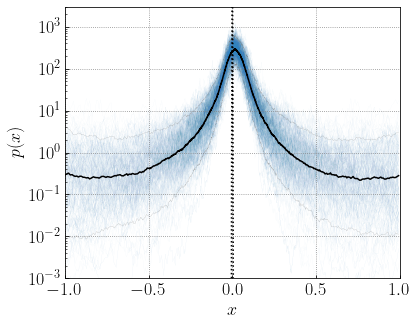

In [9]:
# Read out rates (note that `dR_dchis = R_ref*fs`)
dR_dchis = np.array(hdata['posterior/dR_dchis'])

# Plot a random subset of traces
fig,ax = plt.subplots(figsize=(6,5))
for i in np.random.choice(range(dR_dchis.shape[1]),300):
    ax.plot(sample_values,dR_dchis[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

# Highlight median and 90% credible bounds
ax.plot(sample_values,np.median(dR_dchis,axis=1),color='black')
ax.plot(sample_values,np.quantile(dR_dchis,0.05,axis=1),color='grey',lw=0.15)
ax.plot(sample_values,np.quantile(dR_dchis,0.95,axis=1),color='grey',lw=0.15)

# Show *true* rate density
# Note that we are assuming we have observed Nobs = 69 events spread over T=2 years
# Give the delta function a tiny width to help with visibility
xs = np.linspace(-1,1,1000)
ys = (69./2.)*np.exp(-xs**2/(2.*0.001**2))/np.sqrt(2.*np.pi*0.001**2)
ax.plot(xs,ys,color='black',ls=':')

# Misc formatting
ax.set_xlim(-1,1)
ax.set_ylim(1e-3,3e3)
ax.tick_params(labelsize=18)
ax.set_yscale('log')
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$p(x)$',fontsize=18)

plt.show()

## Case 3: Gaussian + Spike

---
Load the sumary file containing output of our autoregressive inference over mock posteriors, assuming a mixture between a Gaussian and delta-function sub-populations

In [10]:
hdata = h5py.File("./ar_gaussian_spike_varyingUncertainty_069_summary.hdf","r")

# List attributes
for key in hdata.attrs.keys():
    print("{0}: {1}".format(key,hdata.attrs[key]))
    
# List groups and datasetes
print("\nGroups:")
print(hdata.keys())

print("\nData sets inside ['posterior']:")
print(hdata['posterior'].keys())

Created_by: process_mock_populations.py
Downloadable_from: 10.5281/zenodo.7600141
Source_code: https://github.com/tcallister/autoregressive-bbh-inference

Groups:
<KeysViewHDF5 ['posterior']>

Data sets inside ['posterior']:
<KeysViewHDF5 ['R_ref', 'ar_std', 'ar_tau', 'chis', 'dR_dchis', 'fs', 'min_log_neff', 'nEff_inj_per_event']>


---
The different `hdata['posterior/']` datasets correspond to the following:

| Name      | Description |
| :---------- | :---------- |
| `R_ref`     | The mean on our AR1 process  |
| `ar_std` | The square of this is the prior variance of our AR process |
| `ar_tau` | The autocorrelation length of our AR process |
| `chis` | The set of mock samples over which `dR_dchis` and `fs` are defined |
| `dR_dchis` | The source-frame volumetric merger $\frac{d\mathcal{R}}{d\chi}$ with units $\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}$ |
| `fs` | The logarithm of this quantity is our AR1 process over $\chi$; this quantity is proportional to `dR_dchis` |
| `nEff_inj_per_event` | Number of effective injections per event informing our Monte Carlo estimate of detection efficiency |
| `min_log_neff` | For each posterior sample, minimum (log10) number of effective posterior samples informing our Monte Carlo estimates of each event's likelihood, taken over all events |

Make a big corner plot of all these quantities:

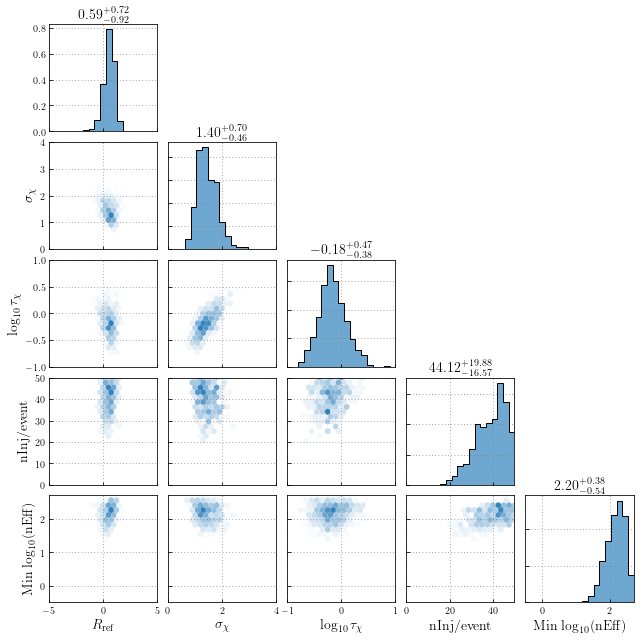

In [11]:
plot_data = {
    'R_ref':{'data':np.log10(hdata['posterior/R_ref'][()]),'plot_bounds':(-5,5),'label':r'$R_\mathrm{ref}$'},
    'ar_std':{'data':hdata['posterior/ar_std'][()],'plot_bounds':(0,4),'label':r'$\sigma_{\chi}$'},
    'ar_tau':{'data':np.log10(hdata['posterior/ar_tau'][()]),'plot_bounds':(-1,1),'label':r'$\log_{10}\tau_{\chi}$'},
    'neff':{'data':hdata['posterior/nEff_inj_per_event'][()],'plot_bounds':(0,50),'label':r'nInj/event'},
    'min_neff':{'data':hdata['posterior/min_log_neff'][()],'plot_bounds':(-0.5,2.7),'label':r'Min $\log_{10}$(nEff)'},
}

fig = plt.figure(figsize=(9,9))
plot_corner(fig,plot_data,'#3182bd')
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()

---
Now let's plot the inferred distribution over $\chi$. We can do this two ways:
* The inferred probability distribution $p(\chi)$, or
* The inferred rate density $d\mathcal{R}/d\chi$

Start with a probability density:

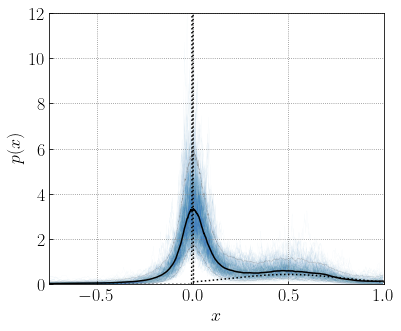

In [12]:
# Read out chi samples and the AR(1) process posteriors
sample_values = np.array(hdata['posterior/chis'])
fs = np.array(hdata['posterior/fs'])

# Loop across samples and normalize to construct a probability density
ps = np.zeros((sample_values.size,fs.shape[1]))
for i in range(fs.shape[1]):
    ps[:,i] = fs[:,i]/np.trapz(fs[:,i],sample_values)

# Plot a random subset of probability distribution posteriors
fig,ax = plt.subplots(figsize=(6,5))
for i in np.random.choice(range(fs.shape[1]),300):
    ax.plot(sample_values,ps[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

# Highlight the mean and a central 90% credible interval
ax.plot(sample_values,np.mean(ps,axis=1),color='black')
ax.plot(sample_values,np.quantile(ps,0.05,axis=1),color='grey',lw=0.15)
ax.plot(sample_values,np.quantile(ps,0.95,axis=1),color='grey',lw=0.15)

# Overplot with the *true* injected probability distribution
# Give the delta function a tiny width to help with visibility
true_mu = 0.5
true_sig = 0.3
f_gaussian = 0.3
xs = np.linspace(-1,1,1000)
ys_gaussian = np.exp(-(xs-true_mu)**2/(2.*true_sig**2))*np.sqrt(2./(np.pi*true_sig**2))/ \
        (erf((1.-true_mu)/np.sqrt(2.*true_sig**2)) - erf((0.-true_mu)/np.sqrt(2.*true_sig**2)))
ys_gaussian[xs<0] = 0
ys_spike = np.exp(-xs**2/(2.*0.001**2))/np.sqrt(2.*np.pi*0.001**2)
ys = f_gaussian*ys_gaussian + (1.-f_gaussian)*ys_spike
ax.plot(xs,ys,color='black',ls=':')

# Misc formatting
ax.set_xlim(-0.75,1)
ax.set_ylim(0,12)
ax.tick_params(labelsize=18)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$p(x)$',fontsize=18)

plt.show()

---
Next plot our recovery of the actual rate density:

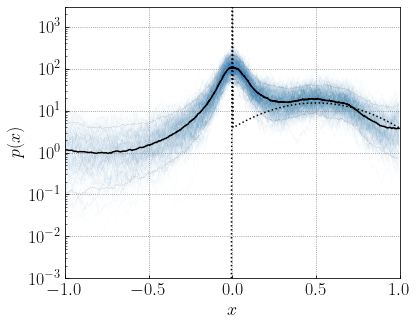

In [13]:
# Read out rates (note that `dR_dchis = R_ref*fs`)
dR_dchis = np.array(hdata['posterior/dR_dchis'])

# Plot a random subset of traces
fig,ax = plt.subplots(figsize=(6,5))
for i in np.random.choice(range(dR_dchis.shape[1]),300):
    ax.plot(sample_values,dR_dchis[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

# Highlight median and 90% credible bounds
ax.plot(sample_values,np.median(dR_dchis,axis=1),color='black')
ax.plot(sample_values,np.quantile(dR_dchis,0.05,axis=1),color='grey',lw=0.15)
ax.plot(sample_values,np.quantile(dR_dchis,0.95,axis=1),color='grey',lw=0.15)

# Show *true* rate density
# Note that we are assuming we have observed Nobs = 69 events spread over T=2 years
# Give the delta function a tiny width to help with visibility
true_mu = 0.5
true_sig = 0.3
f_gaussian = 0.3
xs = np.linspace(-1,1,1000)
ys_gaussian = np.exp(-(xs-true_mu)**2/(2.*true_sig**2))*np.sqrt(2./(np.pi*true_sig**2))/ \
        (erf((1.-true_mu)/np.sqrt(2.*true_sig**2)) - erf((0.-true_mu)/np.sqrt(2.*true_sig**2)))
ys_gaussian[xs<0] = 0
ys_spike = np.exp(-xs**2/(2.*0.001**2))/np.sqrt(2.*np.pi*0.001**2)
ys = (69./2.)*(f_gaussian*ys_gaussian + (1.-f_gaussian)*ys_spike)
ax.plot(xs,ys,color='black',ls=':')

# Misc formatting
ax.set_xlim(-1,1)
ax.set_ylim(1e-3,3e3)
ax.tick_params(labelsize=18)
ax.set_yscale('log')
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$p(x)$',fontsize=18)

plt.show()

## Case 4: Half-Normal

---
Load the sumary file containing output of our autoregressive inference over mock posteriors, assuming a half-normal population:

In [14]:
hdata = h5py.File("./ar_half_normal_varyingUncertainty_069_summary.hdf","r")

# List attributes
for key in hdata.attrs.keys():
    print("{0}: {1}".format(key,hdata.attrs[key]))
    
# List groups and datasetes
print("\nGroups:")
print(hdata.keys())

print("\nData sets inside ['posterior']:")
print(hdata['posterior'].keys())

Created_by: process_mock_populations.py
Downloadable_from: 10.5281/zenodo.7600141
Source_code: https://github.com/tcallister/autoregressive-bbh-inference

Groups:
<KeysViewHDF5 ['posterior']>

Data sets inside ['posterior']:
<KeysViewHDF5 ['R_ref', 'ar_std', 'ar_tau', 'chis', 'dR_dchis', 'fs', 'min_log_neff', 'nEff_inj_per_event']>


---
The different `hdata['posterior/']` datasets correspond to the following:

| Name      | Description |
| :---------- | :---------- |
| `R_ref`     | The mean on our AR1 process  |
| `ar_std` | The square of this is the prior variance of our AR process |
| `ar_tau` | The autocorrelation length of our AR process |
| `chis` | The set of mock samples over which `dR_dchis` and `fs` are defined |
| `dR_dchis` | The source-frame volumetric merger $\frac{d\mathcal{R}}{d\chi}$ with units $\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}$ |
| `fs` | The logarithm of this quantity is our AR1 process over $\chi$; this quantity is proportional to `dR_dchis` |
| `nEff_inj_per_event` | Number of effective injections per event informing our Monte Carlo estimate of detection efficiency |
| `min_log_neff` | For each posterior sample, minimum (log10) number of effective posterior samples informing our Monte Carlo estimates of each event's likelihood, taken over all events |

Make a big corner plot of all these quantities:

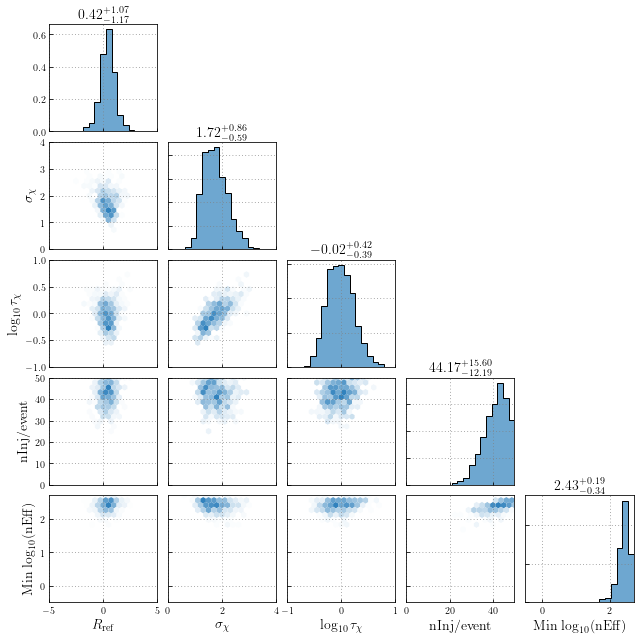

In [15]:
plot_data = {
    'R_ref':{'data':np.log10(hdata['posterior/R_ref'][()]),'plot_bounds':(-5,5),'label':r'$R_\mathrm{ref}$'},
    'ar_std':{'data':hdata['posterior/ar_std'][()],'plot_bounds':(0,4),'label':r'$\sigma_{\chi}$'},
    'ar_tau':{'data':np.log10(hdata['posterior/ar_tau'][()]),'plot_bounds':(-1,1),'label':r'$\log_{10}\tau_{\chi}$'},
    'neff':{'data':hdata['posterior/nEff_inj_per_event'][()],'plot_bounds':(0,50),'label':r'nInj/event'},
    'min_neff':{'data':hdata['posterior/min_log_neff'][()],'plot_bounds':(-0.5,2.7),'label':r'Min $\log_{10}$(nEff)'},
}

fig = plt.figure(figsize=(9,9))
plot_corner(fig,plot_data,'#3182bd')
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()

---
Now let's plot the inferred distribution over $\chi$. We can do this two ways:
* The inferred probability distribution $p(\chi)$, or
* The inferred rate density $d\mathcal{R}/d\chi$

Start with a probability density:

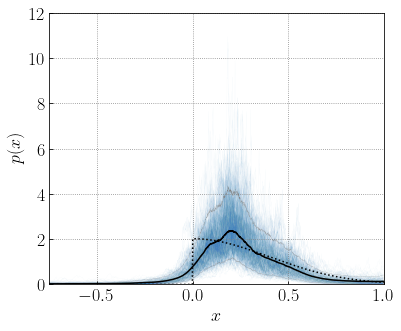

In [16]:
# Read out chi samples and the AR(1) process posteriors
sample_values = np.array(hdata['posterior/chis'])
fs = np.array(hdata['posterior/fs'])

# Loop across samples and normalize to construct a probability density
ps = np.zeros((sample_values.size,fs.shape[1]))
for i in range(fs.shape[1]):
    ps[:,i] = fs[:,i]/np.trapz(fs[:,i],sample_values)

# Plot a random subset of probability distribution posteriors
fig,ax = plt.subplots(figsize=(6,5))
for i in np.random.choice(range(fs.shape[1]),300):
    ax.plot(sample_values,ps[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

# Highlight the mean and a central 90% credible interval
ax.plot(sample_values,np.mean(ps,axis=1),color='black')
ax.plot(sample_values,np.quantile(ps,0.05,axis=1),color='grey',lw=0.15)
ax.plot(sample_values,np.quantile(ps,0.95,axis=1),color='grey',lw=0.15)

# Overplot with the *true* injected probability distribution
sig_pop = 0.4
xs = np.linspace(-1,1,1000)
ys = np.exp(-xs**2/(2.*sig_pop**2))*np.sqrt(2./(np.pi*sig_pop**2))
ys /= erf(1./np.sqrt(2.*sig_pop**2)) 
ys[xs<0] = 0
ax.plot(xs,ys,color='black',ls=':')

# Misc formatting
ax.set_xlim(-0.75,1)
ax.set_ylim(0,12)
ax.tick_params(labelsize=18)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$p(x)$',fontsize=18)

plt.show()

---
Next plot our recovery of the actual rate density:

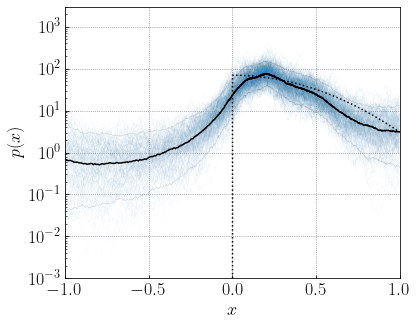

In [17]:
# Read out rates (note that `dR_dchis = R_ref*fs`)
dR_dchis = np.array(hdata['posterior/dR_dchis'])

# Plot a random subset of traces
fig,ax = plt.subplots(figsize=(6,5))
for i in np.random.choice(range(dR_dchis.shape[1]),300):
    ax.plot(sample_values,dR_dchis[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

# Highlight median and 90% credible bounds
ax.plot(sample_values,np.median(dR_dchis,axis=1),color='black')
ax.plot(sample_values,np.quantile(dR_dchis,0.05,axis=1),color='grey',lw=0.15)
ax.plot(sample_values,np.quantile(dR_dchis,0.95,axis=1),color='grey',lw=0.15)

# Show *true* rate density
# Note that we are assuming we have observed Nobs = 69 events spread over T=2 years
sig_pop = 0.4
xs = np.linspace(-1,1,1000)
ys = (69./2.)*np.exp(-xs**2/(2.*sig_pop**2))*np.sqrt(2./(np.pi*sig_pop**2))/erf(1./np.sqrt(2.*sig_pop**2))
ys[xs<0] = 0
ax.plot(xs,ys,color='black',ls=':')

# Misc formatting
ax.set_xlim(-1,1)
ax.set_ylim(1e-3,3e3)
ax.tick_params(labelsize=18)
ax.set_yscale('log')
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$p(x)$',fontsize=18)

plt.show()